# Converting CSV to JSON

In [1]:
import pandas as pd
import json
from pathlib import Path

data_dir = Path("/Users/basusmac/Desktop/Github Repositories/NLP Project/SQuAD-UR") 

df_train = pd.read_csv(data_dir / "squad2_train_urdu_complete.csv")
df_dev   = pd.read_csv(data_dir / "squad2_dev_urdu_complete.csv")

def normalize_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # ensure title exists
    for old in ["title", "article_title", "article", "doc_title"]:
        if old in df.columns:
            df = df.rename(columns={old: "title"})
            break

    # ensure basic columns
    for col in ["title", "context_urdu", "question_urdu"]:
        if col not in df.columns:
            raise ValueError(f"Missing required column {col}")

    # answers
    if "answer_text_urdu" in df.columns:
        df["answer_ur"] = df["answer_text_urdu"].fillna("")
    elif "answer_text" in df.columns:
        df["answer_ur"] = df["answer_text"].fillna("")
    else:
        df["answer_ur"] = ""

    # is_impossible
    if "is_impossible" not in df.columns:
        df["is_impossible"] = False

    return df

df_train_n = normalize_df(df_train)
df_dev_n   = normalize_df(df_dev)

In [2]:
def build_squad_json(df: pd.DataFrame):
    df = df.copy()
    data = []

    grouped = df.groupby(["title", "context_urdu"], dropna=False)

    for (title, context_ur), group in grouped:
        paragraph = {
            "context": str(context_ur),
            "qas": []
        }
        for idx, row in group.iterrows():
            q_text = str(row["question_urdu"])
            ans_text = str(row["answer_ur"]).strip()
            is_impossible = bool(row["is_impossible"])
            q_id = str(row["id"]) if "id" in row and not pd.isna(row["id"]) else f"urdu-{idx}"

            if is_impossible or ans_text == "":
                qa = {
                    "id": q_id,
                    "question": q_text,
                    "answers": [],
                    "is_impossible": True,
                }
            else:
                ctx = str(context_ur)
                start_idx = ctx.find(ans_text)
                if start_idx == -1:
                    start_idx = 0  # log later if you want

                qa = {
                    "id": q_id,
                    "question": q_text,
                    "answers": [{
                        "text": ans_text,
                        "answer_start": start_idx
                    }],
                    "is_impossible": False,
                }

            paragraph["qas"].append(qa)

        data.append({
            "title": str(title),
            "paragraphs": [paragraph],
        })

    return {"version": "v2.0_urdu", "data": data}

train_json = build_squad_json(df_train_n)
dev_json   = build_squad_json(df_dev_n)

with open(data_dir / "train.json", "w", encoding="utf-8") as f:
    json.dump(train_json, f, ensure_ascii=False, indent=2)

with open(data_dir / "dev.json", "w", encoding="utf-8") as f:
    json.dump(dev_json, f, ensure_ascii=False, indent=2)

# Pre Processing

### Imports and Data

In [3]:
import json
from pathlib import Path

import numpy as np
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
import string

# Paths – adjust if needed
data_dir = Path("/Users/basusmac/Desktop/Github Repositories/NLP Project/SQuAD")
train_json_path = data_dir / "train.json"
dev_json_path   = data_dir / "dev.json"

### Load JSON and flatten SQuAD structure

In [4]:
with open(train_json_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)

with open(dev_json_path, "r", encoding="utf-8") as f:
    dev_data = json.load(f)

print("Train articles:", len(train_data["data"]))
print("Dev articles:", len(dev_data["data"]))

Train articles: 106458
Dev articles: 8606


#### Flatten SQuAD

In [5]:
def flatten_squad(data_dict):
    rows = []
    for article in data_dict["data"]:
        title = article.get("title", "")
        for para in article["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                is_impossible = qa.get("is_impossible", False)
                qid = qa.get("id", "")

                # SQuAD v2.0: answers can be empty for impossible questions
                if qa.get("answers") and len(qa["answers"]) > 0:
                    ans_text = qa["answers"][0]["text"]
                    ans_start = qa["answers"][0]["answer_start"]
                else:
                    ans_text = ""
                    ans_start = -1

                rows.append(
                    {
                        "id": qid,
                        "title": title,
                        "context": context,
                        "question": question,
                        "answer_text": ans_text,
                        "answer_start": ans_start,
                        "is_impossible": is_impossible,
                    }
                )
    return rows

train_rows = flatten_squad(train_data)
dev_rows   = flatten_squad(dev_data)

print("Flattened train rows:", len(train_rows))
print("Flattened dev rows:", len(dev_rows))
train_rows[0]

Flattened train rows: 130319
Flattened dev rows: 11873


{'id': '56d675ed1c8504140094713d',
 'title': '2008_Sichuan_earthquake',
 'context': '[" زلزلے نے محققین کو مستقبل کے زلزلے کی پیش گوئیوں کا ماڈل بنانے کے لئے ڈیٹا کو اپ گریڈ کرنے کے مواقع بھی فراہم کیے۔ انٹر میگنیٹ لانجو جیومگنیٹک آبزرویٹری کے اعداد و شمار کا استعمال کرتے ہوئے ، مقدونیہ میں سکوپیا کے ایس ایس سیریل اینڈ میتھوڈیس یونیورسٹی کے جیولوجسٹز لازو پیکیوسکی اور بلغاریہ اکیڈمی آف سائنسز کے اسٹراکیمر موروڈیف نے جھیل کی کشش ثقل صلاحیت کے ساتھ جیومگنیٹزم پر ••حصائیتوں•••• کے جمع کرکے وقت کی پیش گوئی کا طریقہ قائم کرنے کی کوشش کی۔ اس طریقہ کار کا استعمال کرتے ہوئے ، کہا جاتا ہے کہ انہوں نے 2008 کے سیچوان زلزلے کے وقت کی پیش گوئی کی تھی ± 1 دن کی درستگی کے ساتھ۔ تاہم ، اسی مطالعہ میں زلزلے کی پیش گوئی کے ماڈل کی حد کو تسلیم کیا گیا ہے ، اور اس کا ذکر نہیں کیا گیا ہے کہ زلزلے کی جگہ کی درستگی سے پیش گوئی کی جاسکتی ہے۔]',
 'question': 'اس طریقہ کار میں استعمال کرنے کے لئے انہوں نے کیا جمع کیا؟',
 'answer_text': '',
 'answer_start': -1,
 'is_impossible': True}

#### Convert to HuggingFace Dataset objects

In [6]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_list(train_rows)
dev_dataset   = Dataset.from_list(dev_rows)

raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": dev_dataset,
})

raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answer_text', 'answer_start', 'is_impossible'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answer_text', 'answer_start', 'is_impossible'],
        num_rows: 11873
    })
})

### Filter to answerable questions

In [7]:
def keep_answerable(example):
    # keep only those with non-empty answer_text and not impossible
    return (not example["is_impossible"]) and (str(example["answer_text"]).strip() != "")

train_answerable = raw_datasets["train"].filter(keep_answerable)
val_answerable   = raw_datasets["validation"].filter(keep_answerable)

print("Train total:", len(raw_datasets["train"]))
print("Train answerable:", len(train_answerable))
print("Val total:", len(raw_datasets["validation"]))
print("Val answerable:", len(val_answerable))

Filter:   0%|          | 0/130319 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11873 [00:00<?, ? examples/s]

Train total: 130319
Train answerable: 0
Val total: 11873
Val answerable: 0


### Load mT5 tokenizer

In [8]:
from transformers import AutoTokenizer, MT5Tokenizer

# Option 1: Explicit slow tokenizer class
tok = MT5Tokenizer.from_pretrained("google/mt5-small")
print("Slow MT5 tokenizer loaded!")

# OR Option 2: Tell AutoTokenizer not to use fast version
# tok = AutoTokenizer.from_pretrained("google/mt5-small", use_fast=False)
# print("AutoTokenizer (slow) loaded!")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.
You are using the default legacy behaviour of the <class 'transformers.models.mt5.tokenization_mt5.MT5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Slow MT5 tokenizer loaded!


In [9]:
model_name = "google/mt5-small"  
tokenizer = AutoTokenizer.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/Users/basusmac/miniconda3/envs/nllb_env/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


## Preprocess function (build input + labels)

In [10]:
max_input_length = 512
max_target_length = 64

def preprocess_function(batch):
    questions = batch["question"]
    contexts  = batch["context"]
    answers   = batch["answer_text"]

    # Build text input for the model
    inputs = []
    for q, c in zip(questions, contexts):
        q = str(q) if q is not None else ""
        c = str(c) if c is not None else ""
        inputs.append(f"question: {q} context: {c}")

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
    )

    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            answers,
            max_length=max_target_length,
            truncation=True,
            padding="max_length",
        )

    labels_ids = labels["input_ids"]

    # Replace pad_token_id with -100 for loss masking
    labels_ids = [
        [(tid if tid != tokenizer.pad_token_id else -100) for tid in seq]
        for seq in labels_ids
    ]
    model_inputs["labels"] = labels_ids

    return model_inputs

In [11]:
tokenized_train = train_answerable.map(
    preprocess_function,
    batched=True,
    remove_columns=train_answerable.column_names,
)

tokenized_val = val_answerable.map(
    preprocess_function,
    batched=True,
    remove_columns=val_answerable.column_names,
)

tokenized_train, tokenized_val

(Dataset({
     features: [],
     num_rows: 0
 }),
 Dataset({
     features: [],
     num_rows: 0
 }))

       context_len_chars  question_len_chars  context_len_words  \
count      130319.000000       130319.000000      130319.000000   
mean          762.376745           58.507739         119.816865   
std           308.659638           73.757111          49.803877   
min           156.000000            1.000000          20.000000   
25%           568.000000           44.000000          89.000000   
50%           699.000000           55.000000         110.000000   
75%           898.000000           69.000000         141.000000   
max          3732.000000        25651.000000         657.000000   

       question_len_words  
count       130319.000000  
mean             9.893822  
std              3.418829  
min              1.000000  
25%              7.000000  
50%              9.000000  
75%             12.000000  
max             40.000000  


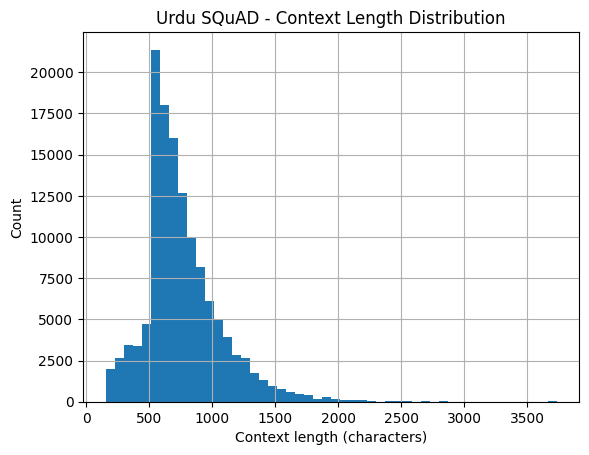

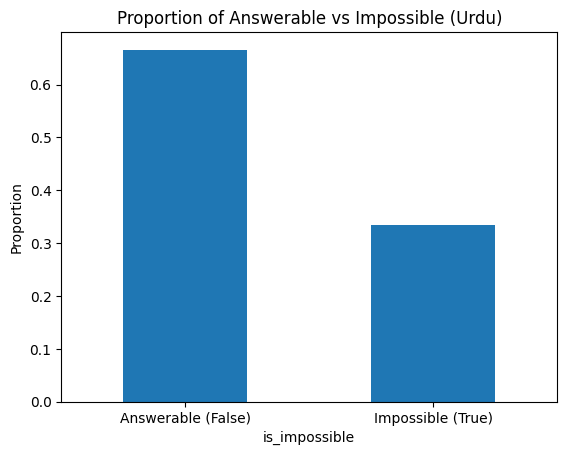

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your combined Urdu train CSV
df = pd.read_csv("/Users/basusmac/Desktop/Github Repositories/NLP Project/SQuAD-UR/squad2_train_urdu_complete.csv")

# Basic cleaning
df["context"] = df["context"].astype(str)
df["question"] = df["question"].astype(str)

# Length features
df["context_len_chars"] = df["context"].str.len()
df["question_len_chars"] = df["question"].str.len()
df["context_len_words"] = df["context"].str.split().str.len()
df["question_len_words"] = df["question"].str.split().str.len()

print(df[["context_len_chars", "question_len_chars",
          "context_len_words", "question_len_words"]].describe())

# Plot: histogram of context lengths (chars)
plt.figure()
df["context_len_chars"].hist(bins=50)
plt.xlabel("Context length (characters)")
plt.ylabel("Count")
plt.title("Urdu SQuAD - Context Length Distribution")
plt.show()

# Plot: answerable vs impossible
if "is_impossible" in df.columns:
    df["is_impossible"] = df["is_impossible"].astype(bool)
    df["is_impossible"].value_counts(normalize=True).plot(kind="bar")
    plt.xticks([0, 1], ["Answerable (False)", "Impossible (True)"], rotation=0)
    plt.ylabel("Proportion")
    plt.title("Proportion of Answerable vs Impossible (Urdu)")
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

pred_df = pd.read_csv("../dataset/mt5_urdu_val_predictions.csv")

def normalize_text(s):
    s = str(s).lower().strip()
    s = "".join(ch for ch in s if ch not in string.punctuation)
    s = " ".join(s.split())
    return s

def f1_score(pred, gold):
    pred_tokens = normalize_text(pred).split()
    gold_tokens = normalize_text(gold).split()
    if len(pred_tokens) == 0 or len(gold_tokens) == 0:
        return float(pred_tokens == gold_tokens)
    common = set(pred_tokens) & set(gold_tokens)
    num_same = sum(min(pred_tokens.count(w), gold_tokens.count(w)) for w in common)
    if num_same == 0:
        return 0.0
    precision = num_same / len(pred_tokens)
    recall = num_same / len(gold_tokens)
    return 2 * precision * recall / (precision + recall)

def exact_match(pred, gold):
    return int(normalize_text(pred) == normalize_text(gold))

pred_df["q_len_words"] = pred_df["question"].astype(str).str.split().str.len()
pred_df["em"] = [exact_match(p, g) for p, g in zip(pred_df["pred_urdu"], pred_df["gold_urdu"])]
pred_df["f1"] = [f1_score(p, g) for p, g in zip(pred_df["pred_urdu"], pred_df["gold_urdu"])]

# Error category
def categorize_row(row):
    if row["em"] == 1:
        return "exact_match"
    elif row["f1"] > 0:
        return "partial_overlap"
    else:
        return "no_overlap"

pred_df["error_type"] = pred_df.apply(categorize_row, axis=1)

print(pred_df["error_type"].value_counts(normalize=True))

# Plot: error type distribution
pred_df["error_type"].value_counts().plot(kind="bar")
plt.title("mT5 Urdu QA - Error Type Distribution")
plt.ylabel("Count")
plt.show()

# Plot: F1 vs question length buckets
bins = [0, 5, 10, 15, 20, 100]
labels = ["0-5", "6-10", "11-15", "16-20", "21+"]
pred_df["q_len_bin"] = pd.cut(pred_df["q_len_words"], bins=bins, labels=labels, right=True)

f1_by_bin = pred_df.groupby("q_len_bin")["f1"].mean()
em_by_bin = pred_df.groupby("q_len_bin")["em"].mean()

f1_by_bin.plot(kind="bar")
plt.title("Average F1 by Question Length (Urdu)")
plt.ylabel("F1")
plt.show()

em_by_bin.plot(kind="bar")
plt.title("Exact Match Rate by Question Length (Urdu)")
plt.ylabel("EM")
plt.show()